# Save the Factory: Feature Engineering Challenge

<img src="https://drive.google.com/uc?id=1QjV8Th9fOK89MhgV-Y1Irn7dTl7ZheP0" width="650">

## Background

In the whimsical town of Widgetville, the mighty Widget Corp stands as the centerpiece, crafting widgets of unmatched quality with a **Ruby** and **Sapphire** magic stones inside. But recently, a trickster sprite seems to have infiltrated the assembly lines, introducing problems and faults to widgets's working procedure and labels. As the company’s freshly appointed Chief Engineering Detective, you are tasked with a mission to unravel this puzzling situation.

## Task

- Your ultimate goal is to effectively classify widgets into two classes: **Ruby** and **Sapphire**.

- You have recovered the labels for a previous month's supply of widgets, and should use these to classify the remaining widgets.

- For every widget, you have an access to the so-called "The Pulse of the Machine" -- a unique numerical representation of each widget, which features 8 magic threads (represented by 187 numbers) woven into the central timeless crystal.
Therefore, each widget is described by (187 x 8) array. You must use these data to recover the **Ruby** and **Sapphire** labels.

- You need to engineer discerning features from the **Pulse of the Machine**, since efficient factory procedures allow you to **only use Decision Tree Classifier** with a limited tree depth as a model, with no hyperparameters change allowed.
  - You can read more about Decision Trees in scikit-learn documentation:
    - https://en.wikipedia.org/wiki/Decision_tree
    - https://scikit-learn.org/stable/modules/tree.html
    - https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
  
- You have two levels of difficulty, producing **Efficient** and **Super Duper Efficient** solutions. These vary by the allowed tree depth.

- Your classification success will be measured by the ROC AUC metric
  - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html

- Your solution for each task should not exceed 5 minutes for training from scratch **AND** inference on the validation/test set on the standard Colab non-GPU instance. This **INCLUDES** features generation (working time of the function that transforms initial Pulse of the Machine into a set of features for the model).

## Deliverables

- We will share the test data 48 hours before the deadline

- Use test data to create `efficient_test_predictions.txt` and `super_duper_efficient_test_predictions.txt` and share these files with us

- Also share this notebook containing your solution so we can reproduce your results and check the time constraints

## Tips
- Aim to create a minimal yet mighty set of derivative features to maintain the elegance and effectiveness of your tools.
- The crystals are indeed **timeless** -- be aware that there are no time series involved.
- There was a rumor that not only labels, but the data itself was corrupted by evil spirits. Is there a way for a possible recovery?
- Ensure your solutions are as clear as the crystal waters of Widgetville’s famed springs by providing them with sufficient documentation.

# Below goes data loading and visualization

In [1]:
import pandas as pd
import numpy as np
np.random.seed(2024)
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

In [2]:
# %pip install gdown
# !gdown 1eIrRyAqckN6zCjPb9VS-2rw7Bup7YhsA

Downloading...
From (original): https://drive.google.com/uc?id=1eIrRyAqckN6zCjPb9VS-2rw7Bup7YhsA
From (redirected): https://drive.google.com/uc?id=1eIrRyAqckN6zCjPb9VS-2rw7Bup7YhsA&confirm=t&uuid=1a8a51f4-ed56-4ab0-b02b-89a94256ff5b
To: /home/alejo/Projects/ai-olympiad/ioai_ml_2024_ruby_detector/FE_hometask_data_v3.pickle
100%|████████████████████████████████████████| 260M/260M [01:02<00:00, 4.20MB/s]


In [2]:
data = pd.read_pickle('FE_hometask_data_v3.pickle')
for key in data.keys():
  print(key)

train
val


In [3]:
X_train = np.array([x[0] for x in data['train'].values()])
y_train = np.array([x[1] for x in data['train'].values()])

X_val = np.array([x[0] for x in data['val'].values()])
y_val = np.array([x[1] for x in data['val'].values()])
# this is temporary as we'll share the test data later
X_test = X_val

In [4]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape

((20240, 187, 8), (20240,), (1456, 187, 8), (1456,), (1456, 187, 8))

In [78]:
import plotly.graph_objects as go
import plotly.express as px

def vis(X, y, use_animation=False, facet_col_wrap=4):
    """
    Visualize pulse data across batches
    
    Args:
        X: array of shape (batch, pulse_len, cnt)
        y: array of labels (0 for Sapphire, 1 for Ruby)
        use_animation: if True, animate across batches. If False, use facets
        facet_col_wrap: number of facets per row when not using animation
    """
    df_list = []
    
    # Create color sequences
    ruby_colors = px.colors.sequential.Reds_r[:8]
    sapphire_colors = px.colors.sequential.Blues_r[:8]
    
    # Create color mapping dictionary
    color_map = {}
    for i in range(8):
        color_map[f'Ruby Channel {i}'] = ruby_colors[i]
        color_map[f'Sapphire Channel {i}'] = sapphire_colors[i]
    
    for batch_idx in range(len(X)):
        for cnt in range(X.shape[2]):
            for time_idx in range(X.shape[1]):
                crystal_type = 'Ruby' if y[batch_idx] else 'Sapphire'
                channel_name = f'{crystal_type} Channel {cnt}'
                df_list.append({
                    'Batch': f'Sample {batch_idx}',
                    'Time': time_idx,
                    'Value': X[batch_idx, time_idx, cnt],
                    'Channel': channel_name,
                    'Type': crystal_type
                })
    
    df = pd.DataFrame(df_list)
    
    # Get global min and max values for consistent y-axis scaling
    y_min = df['Value'].min()
    y_max = df['Value'].max()
    
    display_args = {'animation_frame': 'Batch'} if use_animation else {'facet_col': 'Batch', 'facet_col_wrap': facet_col_wrap}
    
    fig = px.line(df, x='Time', y='Value', color='Channel',
                 color_discrete_map=color_map,
                 title='Pulse Data',
                 **display_args)

    fig.update_layout(
        width=1000,
        height=600,
        showlegend=True,
        plot_bgcolor='white',
        yaxis=dict(range=[y_min, y_max])  # Set consistent y-axis range
    )
    
    # For faceted plots, update all yaxis ranges
    if not use_animation:
        for i in range(len(fig.layout.annotations)):
            fig.update_yaxes(range=[y_min, y_max], row=1, col=i+1)
    
    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
    
    fig.show()

In [79]:
import plotly.graph_objects as go
import plotly.express as px

def vis_overlay(X1, X2, y1, y2):
    df_list = []
    
    # Create color sequences
    ruby_colors = px.colors.sequential.Reds_r[:8]
    sapphire_colors = px.colors.sequential.Blues_r[:8]
    
    # Create color mapping dictionary
    color_map = {}
    for i in range(8):
        color_map[f'Ruby Channel {i}'] = ruby_colors[i]
        color_map[f'Sapphire Channel {i}'] = sapphire_colors[i]
    
    # Process datasets
    for batch_idx in range(min(len(X1), len(X2))):
        for cnt in range(X1.shape[2]):
            for time_idx in range(X1.shape[1]):    
                # First dataset
                channel_name1 = f'{"Sapphire" if y1[batch_idx] == 0 else "Ruby"} Channel {cnt}'
                df_list.append({
                    'Batch': f'Sample {batch_idx}',
                    'Time': time_idx,
                    'Value': X1[batch_idx, time_idx, cnt],
                    'Channel': channel_name1
                })
                
                # Second dataset
                channel_name2 = f'{"Sapphire" if y2[batch_idx] == 0 else "Ruby"} Channel {cnt}'
                df_list.append({
                    'Batch': f'Sample {batch_idx}',
                    'Time': time_idx,
                    'Value': X2[batch_idx, time_idx, cnt],
                    'Channel': channel_name2
                })
    
    df = pd.DataFrame(df_list)
    
    # Get global min and max values for consistent y-axis scaling
    y_min = df['Value'].min()
    y_max = df['Value'].max()
    
    # Create figure combining both datasets
    fig = px.line(df, x='Time', y='Value', 
                 color='Channel',
                 animation_frame='Batch',
                 color_discrete_map=color_map,  # Use the color mapping
                 title='Pulse Data Comparison')

    fig.update_layout(
        width=1000,
        height=600,
        showlegend=True,
        plot_bgcolor='white',
        yaxis=dict(range=[y_min, y_max])
    )
    
    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
    
    fig.show()

In [105]:
def process_data(X, k=1):
    mean_by_channel = X.mean(axis=0, keepdims=True)
    # Get k-th derivative along time axis (axis 1)
    X = np.diff(X, n=k, axis=1)
    X = X - X.mean(axis=0, keepdims=True)
    # Reconstruct signal by cumulative sum along time axis
    # X = np.cumsum(X, axis=1)
    # X = X + mean_by_channel[:, :-1]
    return X

n = 12
X_new = process_data(X_train, k=1)
idx = np.random.choice(range(X_new.shape[0]), n)
# df = vis(X_new[idx], y_train[idx])
df = vis(X_new[:n], y_train[:n])


In [63]:
px.colors.sequential.Reds_r

['rgb(103,0,13)',
 'rgb(165,15,21)',
 'rgb(203,24,29)',
 'rgb(239,59,44)',
 'rgb(251,106,74)',
 'rgb(252,146,114)',
 'rgb(252,187,161)',
 'rgb(254,224,210)']

In [45]:
def find_closest_opposite(X, y):
    # Convert y to numpy array if needed
    y = np.array(y)
    
    # Reshape X to 2D for easier distance calculation
    X_flat = X.reshape(X.shape[0], -1)
    
    # Split data by crystal type
    ruby_mask = y == 1
    sapphire_mask = ~ruby_mask
    
    ruby_samples = X_flat[ruby_mask]
    sapphire_samples = X_flat[sapphire_mask]
    
    # Initialize array to store closest opposites
    closest_opposites = np.zeros_like(X)
    closest_labels = np.zeros_like(y)
    
    # Find closest opposite crystal type for each sample
    for mask, samples, opposite_samples, opposite_mask in [
        (ruby_mask, ruby_samples, sapphire_samples, sapphire_mask),
        (sapphire_mask, sapphire_samples, ruby_samples, ruby_mask)
    ]:
        # Calculate pairwise distances between all samples and their opposites
        distances = np.linalg.norm(samples[:, None, :] - opposite_samples[None, :, :], axis=2)
        closest_indices = np.argmin(distances, axis=1)
        
        # Get indices where the mask is True
        mask_indices = np.where(mask)[0]
        
        # Update closest opposites and labels in one go
        closest_opposites[mask_indices] = X[opposite_mask][closest_indices]
        closest_labels[mask_indices] = np.where(y[mask_indices] == 1, 0, 1)
    
    return closest_opposites, closest_labels


In [71]:
n = 200
# X_train_sample = process_data(X_train[:n])
X_train_sample = X_train[:n]
y_train_sample = y_train[:n]

k = 20
X_closest, y_closest = find_closest_opposite(X_train_sample, y_train_sample)  # Pass complete dataset
X_all = np.concatenate([X_train_sample[:k], X_closest[:k]])  # Only use closest matches for selected indices
y_all = np.concatenate([y_train_sample[:k], y_closest[:k]])
# vis(X_all, y_all)
vis_overlay(X_train_sample[:k], X_closest[:k], y_train_sample[:k], y_closest[:k])


In [121]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

X_diff = np.diff(X_train, axis=1)
X_diff = X_diff - X_diff.mean(axis=0, keepdims=True)

# Apply t-SNE 
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_diff.reshape(len(X_diff), -1))

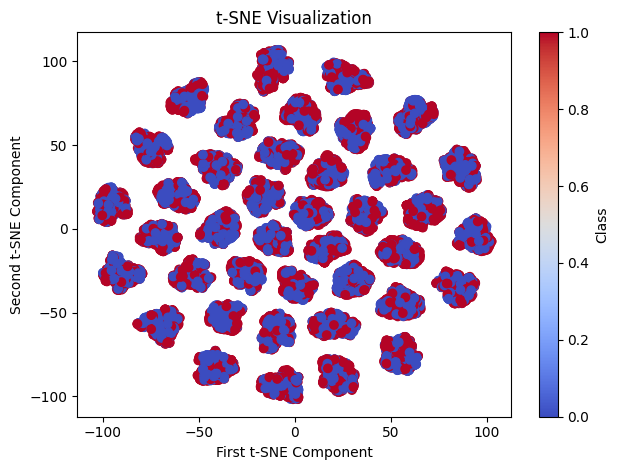

In [123]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

ax2 = plt.gca()

# Plot t-SNE results
scatter2 = ax2.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train, cmap='coolwarm')
ax2.set_title('t-SNE Visualization')
ax2.set_xlabel('First t-SNE Component')
ax2.set_ylabel('Second t-SNE Component')

# Add colorbars
plt.colorbar(scatter2, ax=ax2, label='Class')

plt.tight_layout()
plt.show()


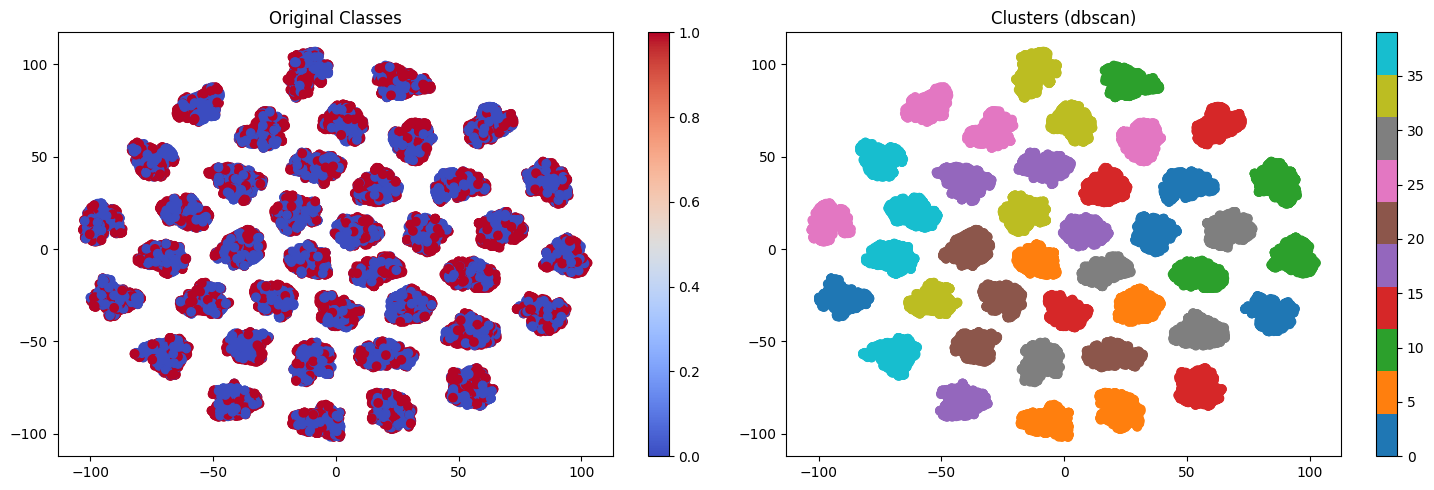

In [124]:
from sklearn.cluster import DBSCAN, KMeans
import numpy as np
import matplotlib.pyplot as plt

# Assuming X_tsne is your t-SNE transformed data from before
def plot_tsne_clusters(X_tsne, y_true, method='dbscan', n_clusters=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot original classes
    scatter1 = ax1.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_true, cmap='coolwarm')
    ax1.set_title('Original Classes')
    plt.colorbar(scatter1, ax=ax1)

    # DBSCAN - automatically determines number of clusters
    clustering = DBSCAN(eps=3, min_samples=5)
    cluster_labels = clustering.fit_predict(X_tsne)
    
    # Plot clustered data
    scatter2 = ax2.scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels, cmap='tab10')
    ax2.set_title(f'Clusters ({method})')
    plt.colorbar(scatter2, ax=ax2)
    
    plt.tight_layout()
    plt.show()
    
    # Return cluster labels for further analysis
    return cluster_labels

# Try both clustering methods
dbscan_labels = plot_tsne_clusters(X_tsne, y_train, method='dbscan')

In [120]:
# Calculate mean along axis 2 for X_train
means = np.mean(X_train, axis=2)

# Create box plot for each cluster using plotly
import plotly.express as px
import pandas as pd

# Create dataframe for plotting
df = pd.DataFrame({
    'Cluster': dbscan_labels,
    'Mean Value': means[:, 0],
    'Label': y_train
})

fig = px.violin(df, x='Cluster', y='Mean Value', color='Label',
             title='Distribution of Mean Values by DBSCAN Cluster',
             labels={'Mean Value': 'Mean value along axis 2'})
fig.show()


In [139]:
def process_data2(X):
    mean_by_channel = X.mean(axis=2, keepdims=True)
    X = np.diff(X, axis=1)
    X = X - X.mean(axis=0, keepdims=True)
    # X = np.cumsum(X, axis=1)
    # X = X + mean_by_channel[:, :-1]
    return X

k = 8
n = 12
X_cluster = process_data2(X_train[dbscan_labels == k])
y_cluster = y_train[dbscan_labels == k]
vis(X_cluster[:n], y_cluster[:n])

In [ ]:
# TODO: create features with the time and size of the pulse

# Functions to evaluate the results
N.B. Do not change it!

In [ ]:
def efficient_eval(train_features, val_features, y_train=y_train):
  model = DecisionTreeClassifier(max_depth=20, random_state=2024).fit(train_features, y_train)
  preds = model.predict(val_features)
  return roc_auc_score(y_val, preds)

def super_duper_efficient_eval(train_features, val_features, y_train=y_train):
  model = DecisionTreeClassifier(max_depth=4, random_state=2024).fit(train_features, y_train)
  preds = model.predict(val_features)
  return roc_auc_score(y_val, preds)

# Functions to write answers to files

Don't change the functions, share the files with us in your final submission.

In [ ]:
def efficient_test_predictions(train_features, test_features, y_train=y_train):
  model = DecisionTreeClassifier(max_depth=20, random_state=2024).fit(train_features, y_train)
  preds = ['1' if x else '0'
           for x in model.predict(test_features)]
  with open('efficient_test_predictions.txt', 'w') as f:
    f.write(''.join(preds))

def super_duper_efficient_test_predictions(train_features, test_features, y_train=y_train):
  model = DecisionTreeClassifier(max_depth=4, random_state=2024).fit(train_features, y_train)
  preds = ['1' if x else '0'
           for x in model.predict(test_features)]
  with open('super_duper_efficient_test_predictions.txt', 'w') as f:
    f.write(''.join(preds))

# Baselines: let's try some simple feature sets!
- every 10th element of a flattened array
- mean value / standard deviation by each axis

In [ ]:
def feature_set_10th(X):
  return np.reshape(X, (X.shape[0], -1))[:, ::10]

def feature_set_mean(X, axis=1):
  return np.mean(X, axis=axis)

def feature_set_std(X, axis=1):
  return np.std(X, axis=axis)

In [ ]:
%%time
efficient_eval(
    feature_set_10th(X_train),
    feature_set_10th(X_val)
)

In [ ]:
%%time
super_duper_efficient_eval(
    feature_set_10th(X_train),
    feature_set_10th(X_val)
)

In [ ]:
%%time
efficient_eval(
    feature_set_mean(X_train, axis=2),
    feature_set_mean(X_val, axis=2)
)

In [ ]:
%%time
efficient_eval(
    feature_set_std(X_train, axis=2),
    feature_set_std(X_val, axis=2)
)

In [ ]:
%%time
super_duper_efficient_eval(
    feature_set_std(X_train, axis=2),
    feature_set_std(X_val, axis=2)
)

Ok, for some reason `feature_set_std, axis=2` was the best.

Don't forget to share the files with us, and please note: any function below (`efficient_test_predictions`, `super_duper_efficient_test_predictions`) should meet the five-minute time limit constraint.

That's how one produces results for the test set.



In [ ]:
efficient_test_predictions(
    feature_set_std(X_train, axis=2),
    feature_set_std(X_test, axis=2)
)

In [ ]:
super_duper_efficient_test_predictions(
    feature_set_std(X_train, axis=2),
    feature_set_std(X_test, axis=2)
)

# UPDATE: the test data!

- Generate test predictions using your functions
- Download your files (use `Files` icon on the left sidebar)
- Upload them somewhere and share the link
- Don't forget to share this notebook as well!

In [ ]:
!gdown 1LmNuET1iDOIS23MTzG-7B99Pfrpwaxhd

In [ ]:
test_data = pd.read_pickle('FE_hometask_data_v3_test.pickle')
X_test = np.array([x[0] for x in test_data['test'].values()])
X_test.shape

In [ ]:
# your solution! replace it
your_feature_set = feature_set_std

efficient_test_predictions(
    your_feature_set(X_train, axis=2),
    your_feature_set(X_test, axis=2)
)

super_duper_efficient_test_predictions(
    your_feature_set(X_train, axis=2),
    your_feature_set(X_test, axis=2)
)